**Objetivo**
**O objetivo dos Dados de Crédito Alemães é minimizar as chances de emitir empréstimos arriscados aos solicitantes, maximizando as chances de lucrar com bons empréstimos. Os perfis demográficos e socioeconómicos de um requerente são considerados pelos gestores de crédito antes de ser tomada uma decisão sobre o seu pedido de empréstimo.**

**O conjunto de dados German Credit é um conjunto de dados disponível publicamente baixado do UCI Machine Learning Repository. Os dados de crédito alemães contêm dados sobre 10 variáveis ​​e a classificação se um solicitante é considerado um risco de crédito Bom ou Ruim para 1.000 solicitantes de empréstimo. A tarefa requer explorar os dados e construir um modelo preditivo para fornecer orientação ao gerente do banco para tomar uma decisão sobre a aprovação de um empréstimo a um candidato em potencial com base em seu perfil.**



Age (numeric)

Sex (text: male, female)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

Housing (text: own, rent, or free)

Saving accounts (text - little, moderate, quite rich, rich)

Checking account (numeric, in DM - Deutsch Mark)

Credit amount (numeric, in DM)

Duration (numeric, in month)

Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)




**A finalidade é maximizar o Risco "Bom" dos clientes.**

# **Importando e Analisando os Dados**

In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module"

In [226]:
df = pd.read_csv("german_credit_data.csv")
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


**Excluindo a coluna de index extra:**

In [227]:
df.drop(columns=["Unnamed: 0"], inplace=True)

**Verificando se há dados nulos:**

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [229]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

**Verificando se há dados duplicados:**

In [230]:
df.duplicated().sum()

0

In [231]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


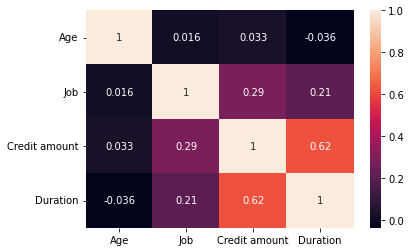

In [232]:
sns.heatmap(df.corr(), annot=True);

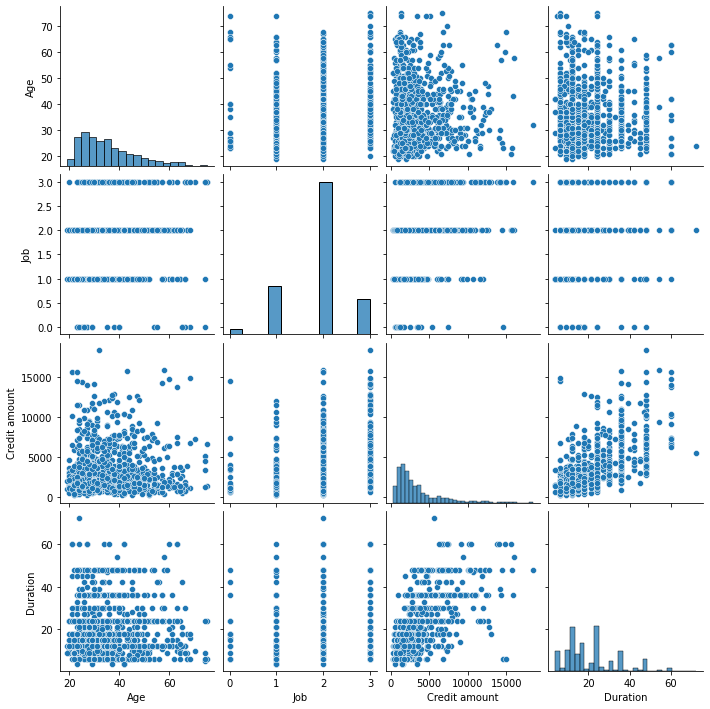

In [233]:
sns.pairplot(df);

# **KNN Classifier**

**Transformando os valores do Target para numéricos:**

In [234]:
df['Risk'] = df['Risk'].map({'bad':0, 'good':1})

In [235]:
from sklearn.neighbors import KNeighborsClassifier

In [237]:
#Separando o que é features e target:
X = df.drop(columns=["Risk"])
y = df["Risk"]

# Dividindo em dados de teste e dados de treino, peguei 30% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas.
pipe_features_num = Pipeline([("std", StandardScaler())])

# Pegando só as features numéricas
features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================
#Vamos tratar as features categóricas.
pipe_features_ohe = Pipeline([("onehot", OneHotEncoder(handle_unknown = "ignore"))]) # Dados Binários

features_ohe = ["Sex"]

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

features_oe = ["Housing", "Saving accounts", "Checking account", "Purpose"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_ohe", pipe_features_ohe, features_ohe),
                                     ("transf_cat_oe", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o KNN para classificação.
pipe_knn = Pipeline([("pre_processador", pre_processador),
                      ("knn", KNeighborsClassifier())])


# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


metrica1 = make_scorer(recall_score, pos_label=1)
metrica2 = make_scorer(precision_score, pos_label=0)


#Montando a grade de parâmetros do estimador (XGBoost)
param_grid_knn = {"knn__weights" : ["uniform", "distance"],
                 "knn__metric" : ["manhattan", "euclidean"],
                 "knn__n_neighbors" : range(2, 21)}


#Motando a grade geral de parâmetros.
model_knn = GridSearchCV(estimator=pipe_knn,
                       param_grid=param_grid_knn ,
                       scoring={"recall": metrica1, "precision" : metrica2}, 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1,
                       refit="recall")

model_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('std',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat_ohe',
                                                            

In [238]:
model_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 19, 'knn__weights': 'uniform'}

In [239]:
model_knn_results = pd.DataFrame(model_knn.cv_results_)
model_knn_results.sort_values(by=["rank_test_precision"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_recall,split1_test_recall,...,split3_test_precision,split4_test_precision,split5_test_precision,split6_test_precision,split7_test_precision,split8_test_precision,split9_test_precision,mean_test_precision,std_test_precision,rank_test_precision
36,0.053645,0.014909,0.051326,0.019630,manhattan,20,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.892857,0.839286,...,0.615385,0.555556,0.705882,0.562500,0.750000,0.500000,0.615385,0.590211,0.083305,1
35,0.044975,0.018893,0.032029,0.011391,manhattan,19,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.892857,0.892857,...,0.533333,0.285714,0.733333,0.562500,0.600000,0.500000,0.500000,0.570589,0.126210,2
53,0.047569,0.013829,0.037221,0.015038,euclidean,9,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.803571,0.910714,...,0.466667,0.500000,0.705882,0.650000,0.600000,0.352941,0.642857,0.568101,0.133349,3
37,0.053775,0.010466,0.045136,0.016784,manhattan,20,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.875000,0.875000,...,0.500000,0.333333,0.800000,0.562500,0.600000,0.428571,0.555556,0.567996,0.133655,4
68,0.047802,0.013804,0.045652,0.018321,euclidean,17,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.839286,0.875000,...,0.500000,0.500000,0.764706,0.615385,0.666667,0.400000,0.777778,0.567751,0.133358,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.073010,0.013712,0.065428,0.012484,euclidean,4,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.696429,0.785714,...,0.307692,0.285714,0.516129,0.483871,0.625000,0.370370,0.428571,0.451747,0.121237,72
39,0.050428,0.016307,0.036830,0.015348,euclidean,2,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.785714,0.875000,...,0.448276,0.350000,0.440000,0.413793,0.571429,0.409091,0.200000,0.442783,0.118201,73
1,0.031573,0.005112,0.021754,0.005048,manhattan,2,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.750000,0.821429,...,0.354839,0.272727,0.440000,0.444444,0.812500,0.333333,0.214286,0.430691,0.159681,74
38,0.046850,0.016590,0.050476,0.016653,euclidean,2,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.625000,0.696429,...,0.333333,0.428571,0.384615,0.428571,0.518519,0.424242,0.375000,0.426879,0.052353,75



Métricas de avaliação de treino:
[[ 88 152]
 [ 48 512]]


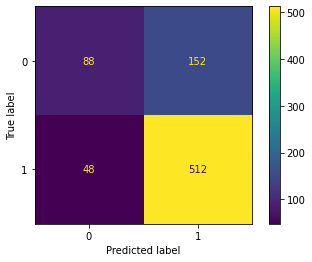

              precision    recall  f1-score   support

           0       0.65      0.37      0.47       240
           1       0.77      0.91      0.84       560

    accuracy                           0.75       800
   macro avg       0.71      0.64      0.65       800
weighted avg       0.73      0.75      0.73       800


Métricas de avaliação de teste:
[[ 16  44]
 [ 11 129]]


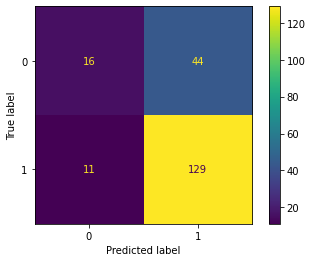

              precision    recall  f1-score   support

           0       0.59      0.27      0.37        60
           1       0.75      0.92      0.82       140

    accuracy                           0.73       200
   macro avg       0.67      0.59      0.60       200
weighted avg       0.70      0.72      0.69       200



In [240]:
### ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = model_knn.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = model_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

**Probabilidade de sair cada diagnóstico:**

In [261]:
probas = model_knn.predict_proba(X_test)

In [262]:
tabela_knn_ob = pd.DataFrame()

In [263]:
tabela_knn_ob["Amostra existente"] = y_test

In [264]:
tabela_knn_ob["Predição"] = y_pred_test

In [265]:
tabela_knn_ob

,Amostra existente,Predição
763,0,1
173,1,1
422,1,1
695,1,1
358,1,1
...,...,...
157,1,1
206,1,1
452,1,1
789,0,0


Salvando a tabela

In [266]:
tabela_knn_ob.to_csv("15-german_credit_knn_ob.csv")

Salvando o estimador...

In [247]:
import pickle

In [268]:
with open("15-credit_knn.pkl", "wb") as f:
    pickle.dump(model_knn, f)

In [ ]:
with open("15-credit_knn.pkl", "rb") as f:
    
    credit_knn = pickle.load(f)

# **Otimização Bayesiana**



---



---



---



In [249]:


def pipe_pre_breast_cancer(drop_not_features=["Risk"], col_target="Risk",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train_ob.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train_ob.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train_ob, X_test_ob, y_train_ob, y_test_ob, pre_processador

In [250]:
X_train_ob, X_test_ob, y_train_ob, y_test_ob, pre_processador = pipe_pre_breast_cancer(drop_not_features=["Risk"], 
                                                                            col_target="Risk",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [251]:
from six.moves import collections_abc
from hyperopt import hp, tpe, fmin, Trials, space_eval

In [252]:
hps_space = {"weights" : hp.choice("weights", ["uniform", "distance"]),  
             "metric" : hp.choice("metric", ["manhattan", "euclidean"]),
             "n_neighbors" : hp.choice("n_neighbors", range(2, 21))}


In [253]:
from sklearn.model_selection import cross_validate

In [254]:
def objective(hps_space):
    
    pipe = Pipeline([("pp", pre_processador),
                     ("knn", KNeighborsClassifier(**hps_space))])

    # =============================================

    splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    results = cross_validate(pipe,
                             X_train_ob, y_train_ob, 
                             cv=splitter,
                             scoring="f1_weighted",
                             n_jobs=-1)

    f1_mean = results["test_score"].mean()

    # como o valor vai ser minimizado, mas queremos MAXIMIZAR o f1, colocamos esse sinal negativo
    return -f1_mean

In [255]:
ts = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=ts,
                max_evals=10)

100%|██████████| 10/10 [00:02<00:00,  3.41it/s, best loss: -0.7163401602245403]


In [256]:
# pré-resposta da otimização
best_hps

{'metric': 1, 'n_neighbors': 11, 'weights': 1}

In [257]:
# a resposta final, vem com o space_eval
best_hps = space_eval(hps_space, best_hps)
best_hps

{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}

In [258]:
KNeighborsClassifier(**best_hps)

KNeighborsClassifier(metric='euclidean', n_neighbors=13, weights='distance')

In [259]:
pipe = Pipeline([("pp", pre_processador),
                 ("knn", KNeighborsClassifier(**best_hps))])

pipe.fit(X_train_ob, y_train_ob)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                     


Métricas de avaliação de treino:
[[270   0]
 [  0 630]]


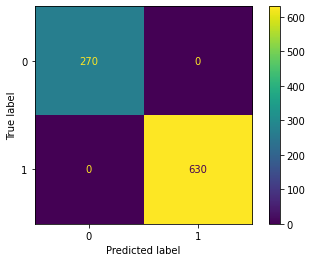

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       270
           1       1.00      1.00      1.00       630

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


Métricas de avaliação de teste:
[[11 19]
 [ 7 63]]


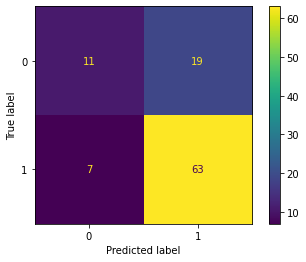

              precision    recall  f1-score   support

           0       0.61      0.37      0.46        30
           1       0.77      0.90      0.83        70

    accuracy                           0.74       100
   macro avg       0.69      0.63      0.64       100
weighted avg       0.72      0.74      0.72       100



In [260]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train_ob = pipe.predict(X_train_ob)

print(confusion_matrix(y_train_ob, y_pred_train_ob))

ConfusionMatrixDisplay.from_predictions(y_train_ob, y_pred_train_ob)
plt.show()

print(classification_report(y_train_ob, y_pred_train_ob))

# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test_ob = pipe.predict(X_test_ob)

print(confusion_matrix(y_test_ob, y_pred_test_ob))

ConfusionMatrixDisplay.from_predictions(y_test_ob, y_pred_test_ob)
plt.show()

print(classification_report(y_test_ob, y_pred_test_ob))

**Já conseguimos equilibrar mais com otimização Bayesiana:**

In [ ]:
probas_y_pred_test_ob = pipe.predict_proba(X_test_ob)

In [ ]:
tabela_knn_ob = pd.DataFrame()

In [ ]:
y_test_ob.shape, y_pred_test_ob.shape

((100,), (100,))

In [ ]:
tabela_knn_ob["Amostra existente"] = y_test_ob

In [ ]:
tabela_knn_ob["Predição"] = y_pred_test_ob

In [ ]:
tabela_knn_ob

,Amostra existente,Predição
440,1,1
561,0,0
220,1,1
696,1,1
810,1,1
...,...,...
386,1,1
788,0,0
654,1,1
705,1,1


Salvando a tabela

In [269]:
tabela_knn_ob.to_csv("15-german_credit_knn_ob.csv")

Salvando o estimador...

In [270]:
import pickle

In [271]:
with open("tabela_knn.pkl", "wb") as f:
    pickle.dump(tabela_knn_ob, f)

In [ ]:
with open("tabela_knn_ob.pkl", "rb") as f:
    
    tabela_knn_ob = pickle.load(f)



---



---



---



#**INTERPRETABILIDADE DO MODELO GLOBALMENTE**

In [212]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,2.766456,-0.670280,0.146949,-0.133710,1.833169,-1.254566,-0.745131,-1.236478,1.073263,good
1,-1.191404,1.491914,0.146949,-0.133710,-0.699707,-0.459026,0.949817,2.248194,1.073263,bad
2,1.183312,-0.670280,-1.383771,-0.133710,-0.699707,1.132053,-0.416562,-0.738668,0.061705,good
3,0.831502,-0.670280,0.146949,-2.016956,-0.699707,-1.254566,1.634247,1.750384,0.567484,good
4,1.535122,-0.670280,0.146949,-2.016956,-0.699707,-1.254566,0.566664,0.256953,-0.949853,bad


Vamos tratar os valores nulos:

In [206]:

si = SimpleImputer(strategy="constant", fill_value="unknown")
si.fit(df[["Saving accounts"]])
       
df["Saving accounts"] = si.transform(df[["Saving accounts"]])

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [208]:
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["Sex"]])

df["Sex"] = ohe.transform(df[["Sex"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [209]:
oe =  OrdinalEncoder()
oe.fit(df[["Housing", "Saving accounts", "Checking account", "Purpose"]])

df[["Housing", "Saving accounts", "Checking account", "Purpose"]] = oe.transform(df[["Housing", "Saving accounts", "Checking account", "Purpose"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [211]:
ssc = StandardScaler()

ssc.fit(df[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']])
h= ssc.transform(df[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']])
df[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']] = h

**Separar em features e target...**

In [213]:
X = df.drop(columns=["Risk"])
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [214]:
knn_shap = KNeighborsClassifier()

In [215]:
knn_shap.fit(X_train.values, y_train)

KNeighborsClassifier()

In [ ]:
!pip install shap
import shap

In [219]:
explainer = shap.KernelExplainer(knn_shap.predict_proba, X_train)

In [ ]:
shap_vals = explainer.shap_values(X_train)

In [221]:
risk = df["Risk"].unique()
print(f"{risk}")

['good' 'bad']


**Features que mais impactaram na escolha das espécies durante a geração do predict:**

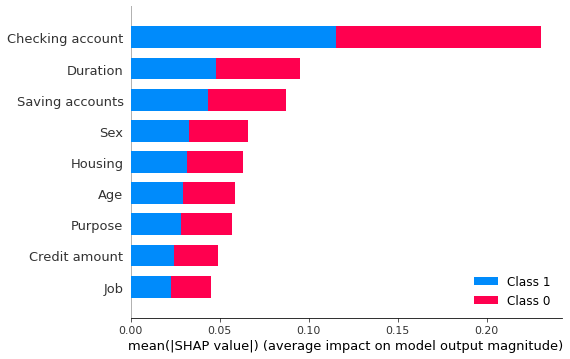

In [222]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")